In [1]:
import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt

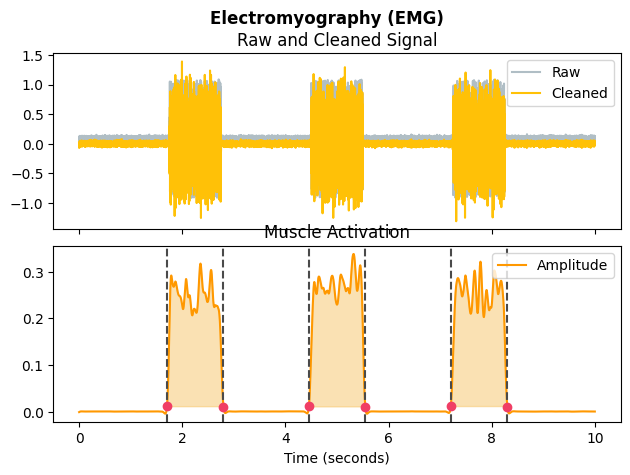

In [2]:
# Simulated EMG data : process and visualize 
emg = nk.emg_simulate(duration=10, sampling_rate=1000, burst_number=3)
signals, info = nk.emg_process(emg, sampling_rate=1000)
nk.emg_plot(signals, info)

In [3]:
# Recorded EDA data : process and visualize 
csv_file_path = 'C:/Users/seinj/Teaching/Recordings_2023_EMG-ECG/csv-data/pb_04_elevated_emg.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path, header=None, names=['Column1'], skiprows=1)

# Extract the single column as a vector
emg_data = df['Column1'].values
print(emg_data[:10])

[-0.003 -0.003 -0.01  -0.006 -0.006 -0.003  0.     0.    -0.003 -0.003]


In [4]:
# process a small time window
# https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/emg/emg_process.html#emg_process
# https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/emg/emg_activation.html#emg_activation
# https://neuropsychology.github.io/NeuroKit/_modules/neurokit2/emg/emg_amplitude.html#emg_amplitude
# https://neuropsychology.github.io/NeuroKit/examples/bio_custom/bio_custom.html
signals_cropped, info = nk.emg_process(emg_data[50000:57000], sampling_rate=1000)
display(signals_cropped)

,EMG_Raw,EMG_Clean,EMG_Amplitude,EMG_Activity,EMG_Onsets,EMG_Offsets
0,-0.013,0.000124,0.001154,0.0,0,0
1,-0.006,0.001532,0.001200,0.0,0,0
2,0.016,0.016664,0.001245,0.0,0,0
3,0.042,0.033370,0.001290,0.0,0,0
4,0.016,-0.005146,0.001335,0.0,0,0
...,...,...,...,...,...,...
6995,-0.026,-0.003105,0.001738,0.0,0,0
6996,-0.042,-0.029126,0.001732,0.0,0,0
6997,-0.003,-0.003119,0.001726,0.0,0,0
6998,0.035,0.019560,0.001721,0.0,0,0


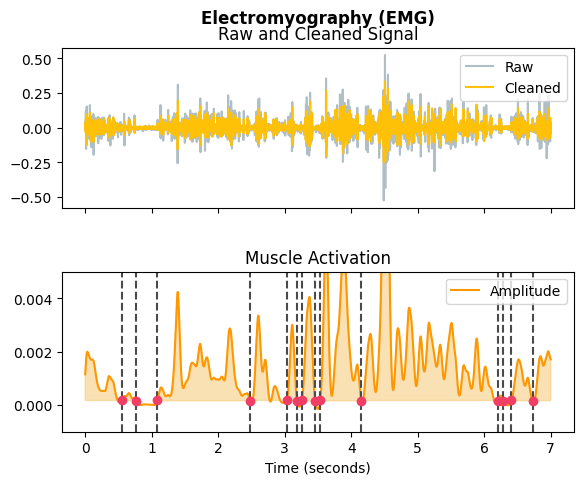

In [5]:
# plot results
nk.emg_plot(signals_cropped, info)

# modify properties of the graphics object
fig = plt.gcf() 
plt.ylim(-0.001,0.005)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

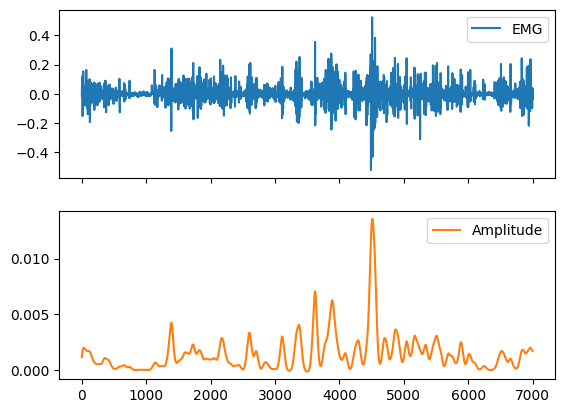

In [9]:
# try it out step by step
cleaned = nk.emg_clean(emg_data[50000:57000], sampling_rate=1000)
amplitude = nk.emg_amplitude(cleaned)
fig = pd.DataFrame({"EMG": emg_data[50000:57000], "Amplitude": amplitude}).plot(subplots=True)

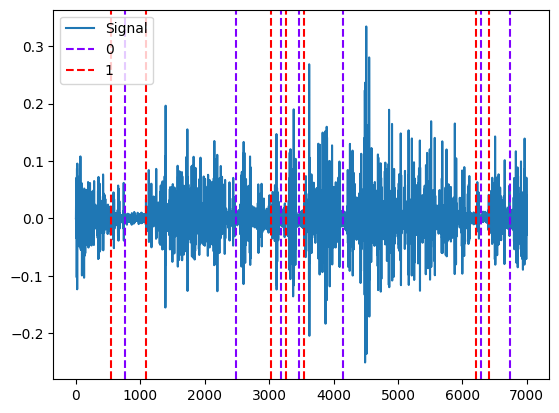

In [11]:
# method "threshold"
activity, info = nk.emg_activation(emg_amplitude=amplitude, method="threshold")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

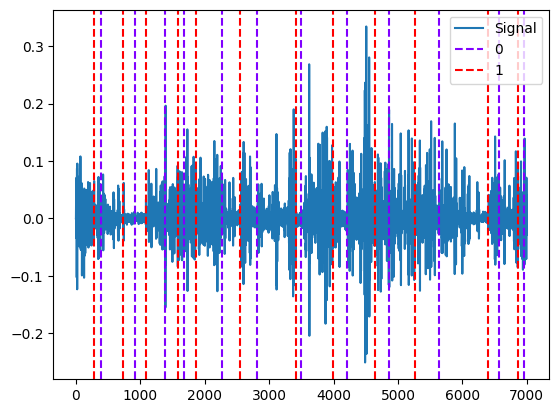

In [12]:
# method "pelt"
activity, info = nk.emg_activation(emg_cleaned=cleaned, method="pelt")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

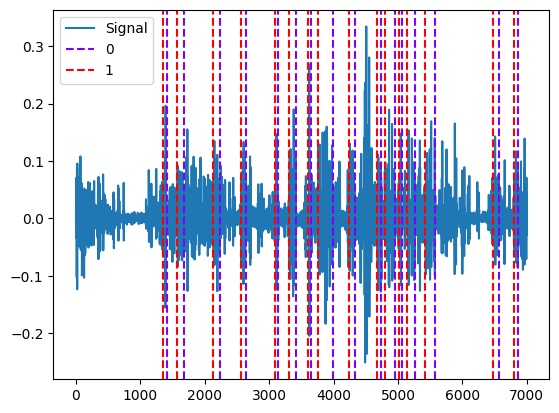

In [13]:
# method "Biosspy"
activity, info = nk.emg_activation(emg_cleaned=cleaned, method="biosppy")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

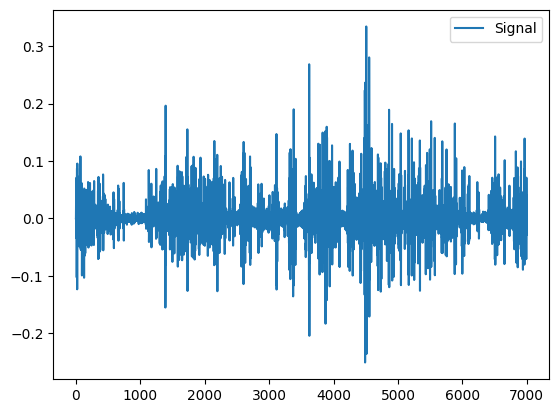

In [16]:
# method "silva"
activity, info = nk.emg_activation(emg_cleaned=cleaned, method="silva")
nk.events_plot([info["EMG_Offsets"], info["EMG_Onsets"]], cleaned)

In [6]:
# process the entire session
signals_full_length, info = nk.emg_process(emg_data, sampling_rate=1000)

In [7]:
# summarize the number of activation and mean amplitude for the given interval
analyze_df = nk.emg_analyze(signals_full_length, method="interval-related")
display(analyze_df)

,EMG_Activation_N,EMG_Amplitude_Mean
0,355.0,0.001436
